## TP2 - ICV
# Realidade Aumentada

### Matheus Tiago Pimenta de Souza - 2018054893

### link vídeo do YouTube: https://youtu.be/oFX3GyU97aQ

O objetivo deste trabalho é, a partir de um vídeo, encontrar os parâmtros intrínsecos da câmera, detectar e localizar alvos nos frames de um vídeo e inserir na cena um cubo tridimensional e um modelo 3D de um Pikachu. Para realizar essa tarefa, deverão ser usadas especialmente funções da OpenCV e da OpenGL, além da Numpy, PIL e a PyGame.

### Calibração:

Para calibrar a câmera, foram escolhidos 20 frames do vídeo, com diferentes distâncias e ângulos do tabuleiro (presente no vídeo). Os frames escolhidos foram: 10, 44, 70, 79, 88, 98, 106, 119, 137, 156, 170, 189, 222, 230, 244, 266, 278, 292, 304 e 311 (de um total de 368 frames obtidos a partir do vídeo no site: *adicionar site*).

A ferramenta utilizada para calibração foi o toolbox de Jean-Yves Bouguet para Matlab/Octave (versão 5.2.0): https://github.com/nghiaho12/camera_calibration_toolbox_octave .

Seguem os resultados da calibração:

Calibration results after optimization (with uncertainties):

Focal Length:          fc = [ 458.82781   452.73805 ] +/- [ 9.80170   8.84958 ]
Principal point:       cc = [ 304.48740   197.66547 ] +/- [ 5.24350   8.65069 ]
Skew:             alpha_c = [ 0.00000 ] +/- [ 0.00000  ]   => angle of pixel axes = 90.00000 +/- 0.00000 degrees
Distortion:            kc = [ 0.06545   0.13870   -0.01095   -0.00684  0.00000 ] +/- [ 0.03398   0.20924   0.00585   0.00469  0.00000 ]
Pixel error:          err = [ 0.17846   0.31269 ]

Note: The numerical errors are approximately three times the standard deviations (for reference).


### Importando bibliotecas e definições básicas

Abaixo importamos as bibliotecas que vamos utilizar, bem como definimos nossa Matriz de parâmetros intrínsicos.

In [1]:
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
f = np.array([458.82781, 452.73805])
c = np.array([304.48740, 197.66547])
Distorcion = np.array([0.06545, 0.13870, -0.01095, -0.00684, 0])

M_int = np.array([[f[0], 0, c[0]],[0, f[1], c[1]],[0, 0, 1]])


Tanto o frame quanto o alvo serão binarizados com o threshhold de Otsu, que computa qual o melhor valor de threshhold. Abaixo temos a execução para o alvo.

(304, 304)


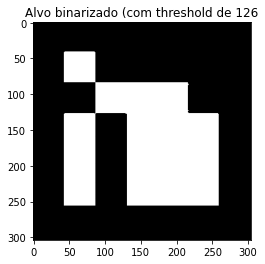

In [3]:
alvo = cv2.imread('alvo.jpg', cv2.IMREAD_GRAYSCALE)
th, bin_alvo = cv2.threshold(alvo, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
h_alvo, w_alvo = bin_alvo.shape

print(alvo.shape)
a,b = alvo.shape
plt.imshow(bin_alvo, cmap="gray")
plt.title("Alvo binarizado (com threshold de %i" %th),
plt.show()


### Detecção e localização dos alvos nos frames

Para demonstrar o funcionamento da parte de detecção e localização dos alvos, vamos rodas os métodos para o primeiro frame.

Primeiro, após tratar e binarizar o frame, obtemos as bordas a partir do método *cv2.Canny()*. Como nosso alvo tem "fundo preto" e um "desenho branco", encontrar as bordas na imagem binarizada (locais com transição de cor) vai encontrar esses alvos.

A partir dessas bordas, usamos o método *cv2.findContours()* para encontrar contornos que essas bordas geram. Com esses contornos poderemos identificar quais representam o alvo que queremos, e assim detecta-los.

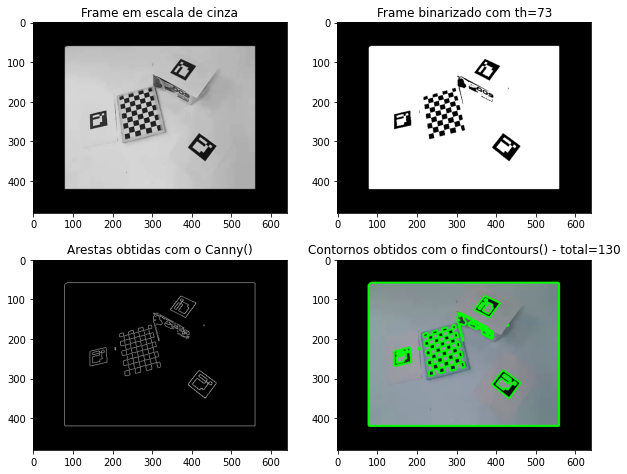

In [4]:
# Definindo função para usar depois na junção de todos os métodos
def get_frame_contours(frame):
  gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  th, bin_frame = cv2.threshold(gray_frame, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  edges = cv2.Canny(bin_frame, 100, 200)
  contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  return contours, bin_frame

cap = cv2.VideoCapture('entrada.mp4')

if (cap.isOpened()== False): 
  print("Erro ao abrir o vídeo")
  exit()

ret, frame = cap.read()
if ret == True:
  gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  th, bin_frame = cv2.threshold(gray_frame, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  edges = cv2.Canny(bin_frame, 100, 200)
  contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  cp_frame = frame.copy()
  cv2.drawContours(cp_frame, contours, -1, (0, 255, 0), 3)
  
  fig = plt.figure(figsize=(10, 8))
  fig.add_subplot(2, 2, 1)
  plt.imshow(gray_frame, cmap="gray")
  plt.title('Frame em escala de cinza'),
  fig.add_subplot(2, 2, 2)
  plt.imshow(bin_frame, cmap="gray")
  plt.title('Frame binarizado com th=%i' %th),
  fig.add_subplot(2, 2, 3)
  plt.imshow(edges, cmap="gray")
  plt.title('Arestas obtidas com o Canny()'), 
  fig.add_subplot(2, 2, 4)
  plt.imshow(cp_frame, cmap="gray")
  plt.title('Contornos obtidos com o findContours() - total=%i' %(len(contours))),
  
  plt.show()
  
else: 
  print("Erro ao ler frame do vídeo")
  exit()



Por conta dos vários outros elementos no frame do vídeo, bem como rúidos e erros de medida, vamos encontrar um conjunto grande de contornos (o primeiro frame por exemplo gera 130). Dessa forma, vamos iterar sobre esse conjunto, identificando quais conjuntos representam um polígono de 4 lados, e que tenham uma área maior que 1000 (para evitar de pegar cada quadradinho do tabuleiro). Para realizar essa tarefa, usamos o método *cv2.approxPolyDP()* para aproximar o polígono a partir dos contornos (com ajuda da *cv2.arcLength()*), e a *cv2.contourArea()* para calcular a área.

In [5]:
def get_potentials_contours(contours_list):
  possibles = []
  for contour in contours_list:
      approx_polig = cv2.approxPolyDP(contour, 0.05*cv2.arcLength(contour, True), True)
      if len(approx_polig) == 4  and cv2.contourArea(approx_polig) > 1000:
        approx_polig = approx_polig.reshape(4, 2)
        possibles.append(approx_polig)
  
  return possibles

possibles = get_potentials_contours(contours)
print("Número de potências alvos: ", len(possibles))

Número de potências alvos:  8


Agora, para cada potencial contorno, vamos calcular a Homografia entre esse contorno e 4 pontos do nosso alvo (as 4 quinas). Com isso, poderemos aplicá-la no frame original (binarizado) e identificar se o resultado é similar ao alvo ou não.

A métrica usada para calcular a similaridade é a norma L2, de forma que quanto mais baixo o erro, mais as imagens são similares. Para ter uma métrica em porcentagem, estamos analizando 1 menos o erro (querendo portanto a maior taxa de similaridade).

Como o alvo pode estar rotacionado, precisamos analizar as 4 possibilidades (0°, 90°, 180°, 270°). O método *get_biggest_similarity()* faz essa análise, retornando a maior similaridade e o número de rotações de 90° no sentido horário. Já o método *get_homog_projections_and_matches()* calcula as homografias, faz as transformações e calcula a similaridade para cada contorno, retornando apenas os bons (acima de 75%, testando empiricamente - normalmente matches ficam acima de 0.8, e não matches chegam no máximo a 0.67).

In [6]:
def get_biggest_similarity(img, target):
  similarity = 0
  angle = 1
  rotate_target = cv2.rotate(target, cv2.ROTATE_90_CLOCKWISE)
  for i in range(4):
    errorL2 = cv2.norm( img, rotate_target, cv2.NORM_L2 )
    aux_similarity = 1 - errorL2 / ( rotate_target.shape[0] * rotate_target.shape[1] )
    if similarity < aux_similarity:
      similarity = aux_similarity
      angle = (i+1)%4
    rotate_target = cv2.rotate(rotate_target, cv2.ROTATE_90_CLOCKWISE)
  
  return similarity, angle

def get_homog_projections_and_matches(bin_frame, possib_contours):
  targets = []
  all_projs = []
  for contour in possib_contours:
      H, mask = cv2.findHomography(contour, np.array([[0,0],[w_alvo-1,0],[w_alvo-1,h_alvo-1],[0,h_alvo-1]]), cv2.RANSAC,5.0)
      reproj = cv2.warpPerspective(bin_frame,H,(w_alvo, h_alvo),flags=cv2.INTER_LINEAR) 

      similarity, angle = get_biggest_similarity(reproj, alvo)
      all_projs.append((contour, reproj, angle, similarity))
      if(similarity >= 0.76):
        targets.append((contour, reproj, angle, similarity))
  
  return targets, all_projs


Vamos vizualizar as projeçõs, mostrando também a melhor taxa de similaridade e sua respectiva rotação.

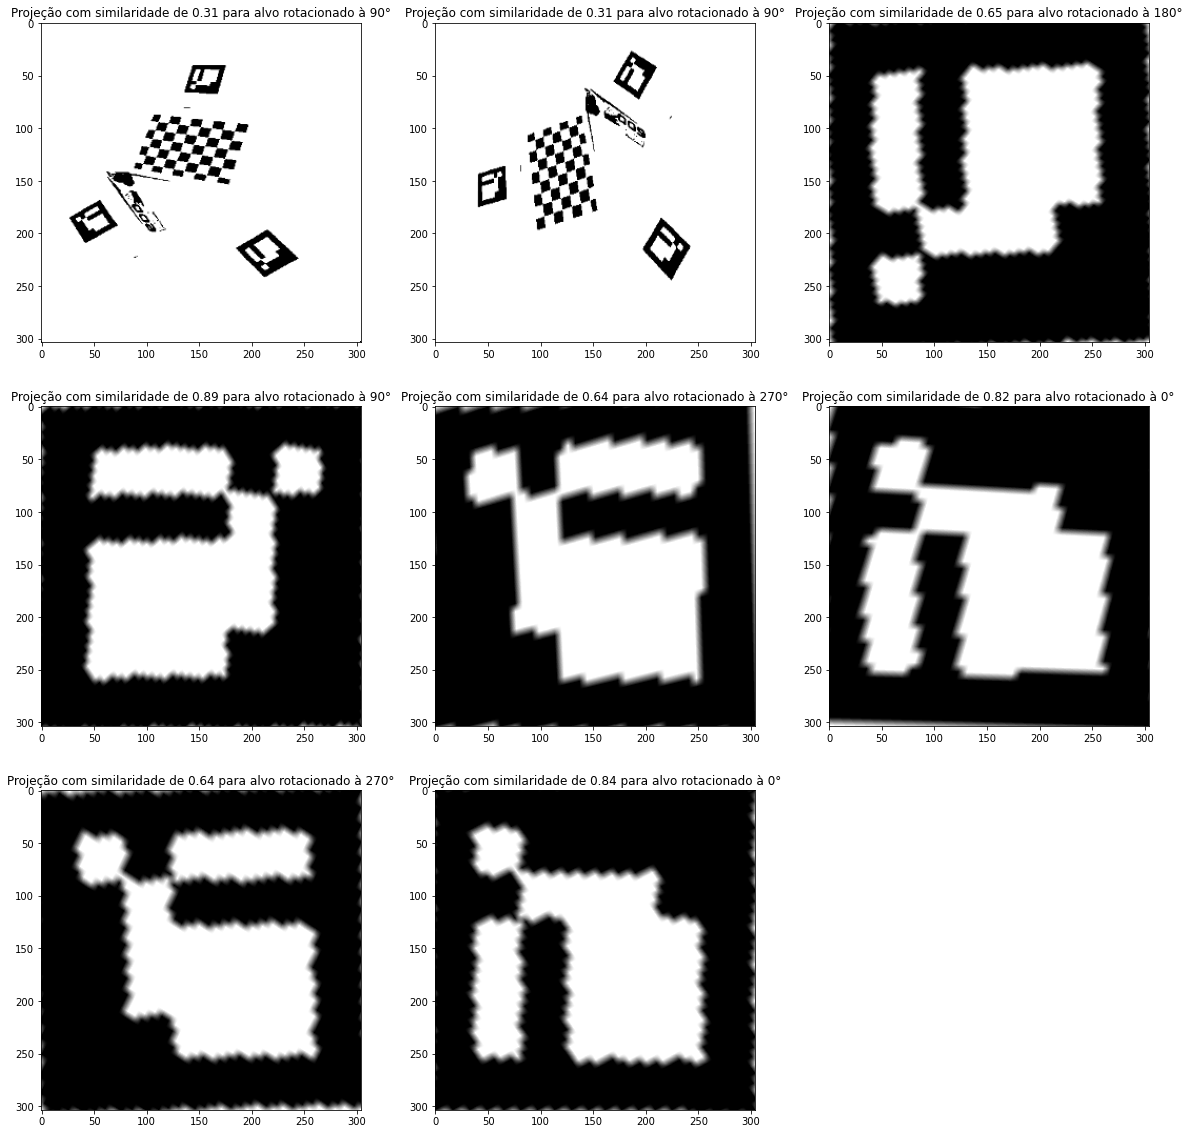

In [7]:
targets, all_projs = get_homog_projections_and_matches(bin_frame, possibles)
fig = plt.figure(figsize=(20, 20))
i=1
for _, img, angle, simi in all_projs:
  fig.add_subplot(3, 3, i)
  title = "Projeção com similaridade de %.2f" % simi + " para alvo rotacionado à " + str(angle*90) + "°"
  plt.title(title)
  i=i+1
  plt.imshow(img, cmap="gray")
plt.show()

Por fim, vamos marcar os alvos no frame do vídeo.

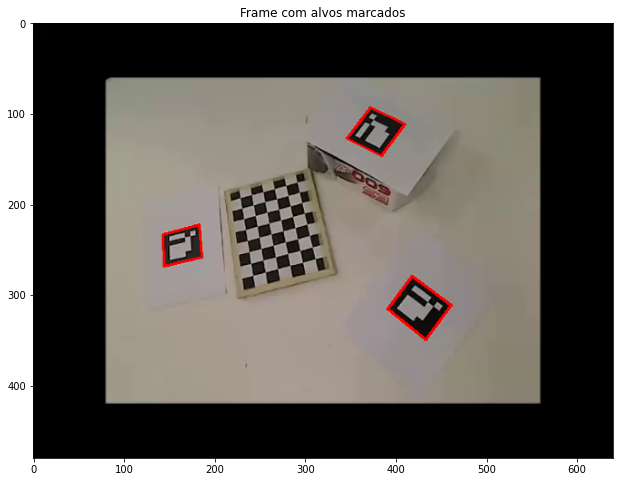

In [8]:
cp_frame = frame.copy()
cp_frame = cv2.cvtColor(cp_frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(16, 8))
contours = []
for contour, _, _, _ in targets:
  contours.append(contour)

cp_frame = cv2.drawContours(image=cp_frame, contours=contours, contourIdx=-1, color=(255, 0, 0), thickness=2)
plt.title("Frame com alvos marcados")
plt.imshow(cp_frame)
plt.show()

### Estimando pose da câmera

Com os alvos detectados e suas respectivas coordenadas, bem como a matriz de parâmetros instrínsecos, podemos estimar a pose da câmera e obter seus parâmetros extrínsecos. Para realizar tal feito, vamos usar o método *cv2.solvePnP()* e o *cv2.Rodrigues()*.

Antes, porém, precisamos definir os pontos de uma base, que após a transformação geram os pontos obtidos na imagem. É necessário também rotacionála com base no mesmo ângulo que obtivemos na etapa anterior. 

In [9]:
def get_model_view_matrix(target_coord, angle):
  object_points = np.array([[-0.5,0.5,0], [0.5,0.5,0], [0.5,-0.5,0], [-0.5,-0.5,0]])
  object_points = np.roll(object_points, angle, 0)

  ret,rvecs, tvecs = cv2.solvePnP(object_points.astype(float), target_coord.astype(float), M_int, Distorcion)

  if(ret):
    rodr, _ = cv2.Rodrigues(rvecs)
    M_modelView = np.block([
        [rodr, tvecs],
        [np.zeros(3),1]
    ])
    M_modelView[1:3, 0:4] = M_modelView[1:3, 0:4]*(-1)
    return np.transpose(M_modelView).astype(np.float64)

results = []
for contour, _, angle, _ in targets:
  results.append(get_model_view_matrix(contour, angle))

print("Matrizes obtidas:")
for m in results:
  print(m)


Matrizes obtidas:
[[-0.65388058 -0.64914652  0.38865021  0.        ]
 [ 0.75603339 -0.58043586  0.30250244  0.        ]
 [ 0.02921811  0.49163301  0.87031218  0.        ]
 [ 2.4244655  -2.34049476 -9.17668253  1.        ]]
[[ 2.10925224e-01 -8.14493790e-01  5.40472400e-01  0.00000000e+00]
 [ 9.66245659e-01  2.57395625e-01  1.08082419e-02  0.00000000e+00]
 [-1.47918477e-01  5.19949380e-01  8.41292319e-01  0.00000000e+00]
 [-3.38143477e+00 -1.16576983e+00 -1.11875327e+01  1.00000000e+00]]
[[  0.76779259  -0.48318524   0.42074525   0.        ]
 [  0.59337991   0.78395402  -0.18252776   0.        ]
 [ -0.24165021   0.38980524   0.88862649   0.        ]
 [  1.60766478   1.7408996  -10.11008627   1.        ]]


### Organizando fluxo:

Para utilizar na renderização, precisamos de um método que englobe todos esses processos, recebendo um frame e retornando a matriz matriz de perspectiva.

In [10]:
def get_Mext_by_frame(frame):
    contours, bin_frame = get_frame_contours(frame)
    possibles = get_potentials_contours(contours)
    targets, _ = get_homog_projections_and_matches(bin_frame, possibles)
    results = []
    for contour, _, angle, _ in targets:
        results.append(get_model_view_matrix(contour, angle))
    
    return results
    

#### Renderização dos Objetos

Agora vamos a última parte do trabalho, que consiste em renderizar um cubo e o pikachu nos alvos detectados. Para isso, faremos uso de funções da OpenGL, seguindo o esqueleto disponibilizado.

Primeiramente, vamos importar as bibliotecas e definir algumas variáveis globais. São usadas var. globais por conta de desenpenho, senão o vídeo fica muito gargalado. As variáveis são: *obj_pikachu*, que vai manter o objeto carregado; *global_cap*, que vai manter o vídeo; e *rot_pikachu*, que mantém o ângulo em que vamos rotacionar o modelo 3D do pikachu. 

Vamos usar também a lib time, para atrasar as renderizações (sem ela o vídeo passa muito rápido).

In [11]:
from OpenGL.GL import *
from OpenGL.GLU import *
from OpenGL.GLUT import *
from PIL import Image

from objloader import * 

import time

global obj_pikachu
obj_pikachu = None

global global_cap
global_cap = cv2.VideoCapture('entrada.mp4')

global rot_pikachu
rot_pikachu = 0

pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


É possível dividir essa etapa em duas: renderizar o frame do vídeo, com uma transformação ortogonal, e renderizar os objetos 3D, que são transformações perspectivas. Para a primeira, temos o método *display_frame()*, que recebe o frame a ser renderizado e faz a transformação ortogonal, a partir do método *gluOrtho2D()*. São utilizado como pontos de referências as quinas do frame. 

In [12]:
def display_frame(frame):

    frame_height, frame_width, _ = frame.shape

    glBindTexture(GL_TEXTURE_2D, glGenTextures(1))
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, frame_width, frame_height, 0, GL_BGR, GL_UNSIGNED_BYTE, frame)

    glDepthMask(GL_FALSE)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    gluOrtho2D(0, frame_width, frame_height, 0)
    
    glEnable(GL_TEXTURE_2D)
    glBegin(GL_QUADS)
    
    glTexCoord2f(0, 0) 
    glVertex2f(0, 0) 
    
    glTexCoord2f(1, 0)
    glVertex2f(frame_width, 0) 
    
    glTexCoord2f(1, 1)
    glVertex2f(frame_width, frame_height) 
    
    glTexCoord2f(0, 1)
    glVertex2f(0, frame_height)

    glEnd()

    glBindTexture(GL_TEXTURE_2D, 0)
    glDepthMask(GL_TRUE)

O outro método é uma extensão do presente no esqueleto, *object3D()*, que recebe a matriz de parâmetros extrínsecos gerada nos métodos definidos anteriormente, e o ângulo que tem que rotacionar o pikachu.

Dessa forma, após dar um push nessa matriz, são renderizados dois cones (formando uma espécie de flecha), o cubo e o pikachu, que é rotacionado.

Devido a prováveis erros de medida na calibração e nos métodos, os objetos não ficaram retinhos no alvo, sendo necessário alguns ajustes.

In [13]:
def object3D(M_ext, rotationAngle):
    global obj_pikachu
    glPushMatrix()
    glLoadMatrixf(M_ext)

    glPushMatrix()
    glTranslatef(0, 0.5, 1)
    glRotate(-90, 1, 0, 0)
    glutWireCone(.2, 1.0, 10, 5)
    glPopMatrix()

    glPushMatrix()
    glTranslatef(0, 0, 1)
    glRotate(-90, 1, 0, 0)
    glutWireCone(.01, 1, 100, 5)
    glPopMatrix()
    
    glTranslatef(0, -0.35, 1.25)
    glPushMatrix()
    glutWireCube(1.5)
    glPopMatrix()
    
    glPushMatrix()
    glScalef(.4, .4, .4)
    glTranslatef(0.5, 0.5, 0.5)
    glRotate(rotationAngle, 0, 0, 1)
    glCallList(obj_pikachu.gl_list)
    glPopMatrix()
    
    glPopMatrix()

Abaixo, temos a *ajuste_intrinsecos_camera()*, como nos slides da matéria, bem como os outros métodos, do esqueleto.

Na *displayCallback()* porém, agora lemos o frame do vídeo, chamamos nosso método para achar M_ext e, para cada matriz encontrada, renderizamos o objeto. Por fim, ajustamos o ângulo, e esperamos um pouco, para o vídeo ficar mais parecido com o original.

In [ ]:
def ajuste_intrinsecos_camera(width, height, M_int):

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity() 

    fx = M_int[0, 0]
    fy = M_int[1, 1]
    fovy = 2*np.arctan(0.5*height/fy)*180/np.pi
    aspect = (width*fy)/(height*fx)

    near = 0.1
    far = 100.0
    gluPerspective(fovy,aspect,near,far)

def initOpenGL():
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)
    glEnable(GL_DEPTH_TEST)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()

def idleCallback():
    glutPostRedisplay()

def displayCallback():
    global global_cap, obj_pikachu, rot_pikachu
        
    ret, frame = global_cap.read()
    if not ret:
        global_cap.release()
        exit()

    display_frame(frame)
    
    # Necessário devido a performace
    if obj_pikachu is None:
        obj_pikachu = OBJ("Pikachu.obj", swapyz=True)
    
    ajuste_intrinsecos_camera(640, 480, M_int)
    
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glEnable(GL_TEXTURE_2D)
    
    M_ext = get_Mext_by_frame(frame)
    for M in M_ext:
        object3D(M, rot_pikachu)
    
    rot_pikachu = (rot_pikachu + 1)%360
    
    time.sleep(0.02)

    glutSwapBuffers()

def init_render():

    dimensions = (640, 480)
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
    glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
    glutInitWindowSize(*dimensions)
    window = glutCreateWindow(b'TP2 ICV - Realidade Aumentada [Cubo e Pikachu]')
    
    initOpenGL()
    
    glutDisplayFunc(displayCallback)
    glutIdleFunc(idleCallback)
    
    glutMainLoop()

init_render()

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti

Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Exception ignored on calling ctypes callback function: <function displayCallback at 0x7f0e3869dc10>
Traceback (most recent call last):
  File "<ipython-input-14-1c7ed80a5c3f>", line 33, in displayCallback
  File "<ipython-input-12-7e0ee612dccc>", line 3, in display_frame
AttributeError: 'NoneType' object has no attribute 'shape'
Excepti